In [144]:
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import zipfile
import random
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical



# Preparing The Data For Keras Model

In [147]:
# Preparing The Data For Keras Model
# Paths
path_test = 'Brain-Tumor-Classification-DataSet/Testing'
path_train = 'Brain-Tumor-Classification-DataSet/Training'

# Use glob to find all image files (supports multiple extensions)
train_img_paths = glob.glob(os.path.join(path_train, '**', '*.*'), recursive=True)
test_img_paths = glob.glob(os.path.join(path_test, '**', '*.*'), recursive=True)

# Initialize data lists
train_img = []
train_labels = []
test_img = []
test_labels = []
img_size = 300

# Helper function to extract folder name dynamically
def get_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Load and preprocess training data
for img_path in train_img_paths:
    img = cv2.imread(img_path)
    if img is not None:  # Ensure valid image
        img = cv2.resize(img, (img_size, img_size))
        train_img.append(img)
        train_labels.append(get_label(img_path))

# Load and preprocess testing data
for img_path in test_img_paths:
    img = cv2.imread(img_path)
    if img is not None:  # Ensure valid image
        img = cv2.resize(img, (img_size, img_size))
        test_img.append(img)
        test_labels.append(get_label(img_path))

# Convert to NumPy arrays and normalize
train_img = np.array(train_img)
test_img = np.array(test_img)

# Dynamically encode labels
unique_labels = sorted(set(train_labels + test_labels))  # Get all unique class names
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Map labels to indices

train_labels_encoded = [label_to_index[label] for label in train_labels]
test_labels_encoded = [label_to_index[label] for label in test_labels]


In [148]:
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)


# Augmenting The Data

In [155]:
# Correct data splitting and encoding
train_x, val_x, train_y, val_y = train_test_split(
    np.array(train_img), 
    np.array(train_labels_encoded),
    test_size=0.2, 
    random_state=42, 
    stratify=np.array(train_labels_encoded)
)

In [157]:
# Normalize images
train_x = train_x / 255.0
val_x = val_x / 255.0

# One-hot encode the labels correctly
train_y = to_categorical(train_y, num_classes=len(unique_labels))
val_y = to_categorical(val_y, num_classes=len(unique_labels))

# Compute class weights based on the current training labels
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(np.argmax(train_y, axis=1)), 
    y=np.argmax(train_y, axis=1)
)
class_weights_dict = dict(enumerate(class_weights))

In [161]:
# Print shapes to verify
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("val_x shape:", val_x.shape)
print("val_y shape:", val_y.shape)

train_x shape: (2296, 300, 300, 3)
train_y shape: (2296, 4)
val_x shape: (574, 300, 300, 3)
val_y shape: (574, 4)


In [163]:
# Use ImageDataGenerator
img_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Handles empty pixels after transformations
)
augmented_train = img_datagen.flow(train_x, train_y, batch_size=32, shuffle=True)




# Some Visualizations

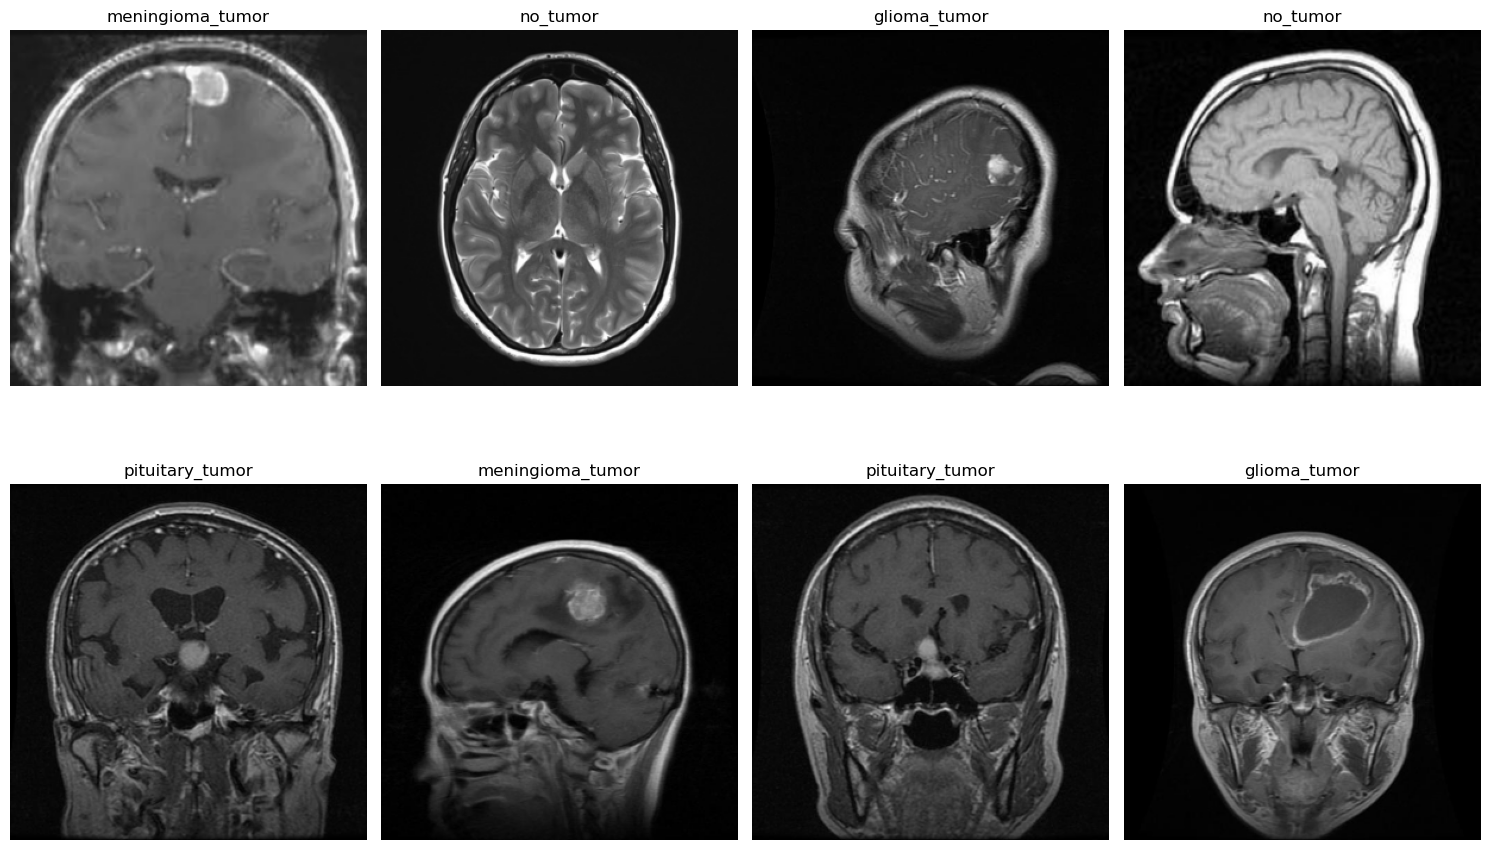

In [165]:
# Use the unique labels you already have
class_names = unique_labels

# Number of images to sample per class
num_images_per_class = 2

# Indices list to store the selected images
indices = []

# Iterate over each class and sample images
for class_index in range(len(class_names)):
    class_indices = np.where(np.argmax(train_y, axis=1) == class_index)[0]  # Get indices of each class
    
    # Ensure we don't sample more than the available images in each class
    num_images_to_sample = min(num_images_per_class, len(class_indices))

    # Sample random indices from the current class
    sampled_indices = random.sample(list(class_indices), num_images_to_sample)
    indices.extend(sampled_indices)

# Shuffle the final indices to mix images from all classes
random.shuffle(indices)

# Plot the sampled images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    # Scale image if necessary
    img = train_x[idx]
    if img.max() <= 1.0:  # Check if the range is [0, 1]
        img = (img * 255).astype('uint8')  # Scale to [0, 255]
    elif img.max() > 255:  # Unusual case: values might need rescaling
        img = (img / img.max() * 255).astype('uint8')

    # Decode label and fetch class name
    label = np.argmax(train_y[idx])  # Decode one-hot encoded label
    class_name = class_names[label]  # Class name
    
    # Plot the image
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()


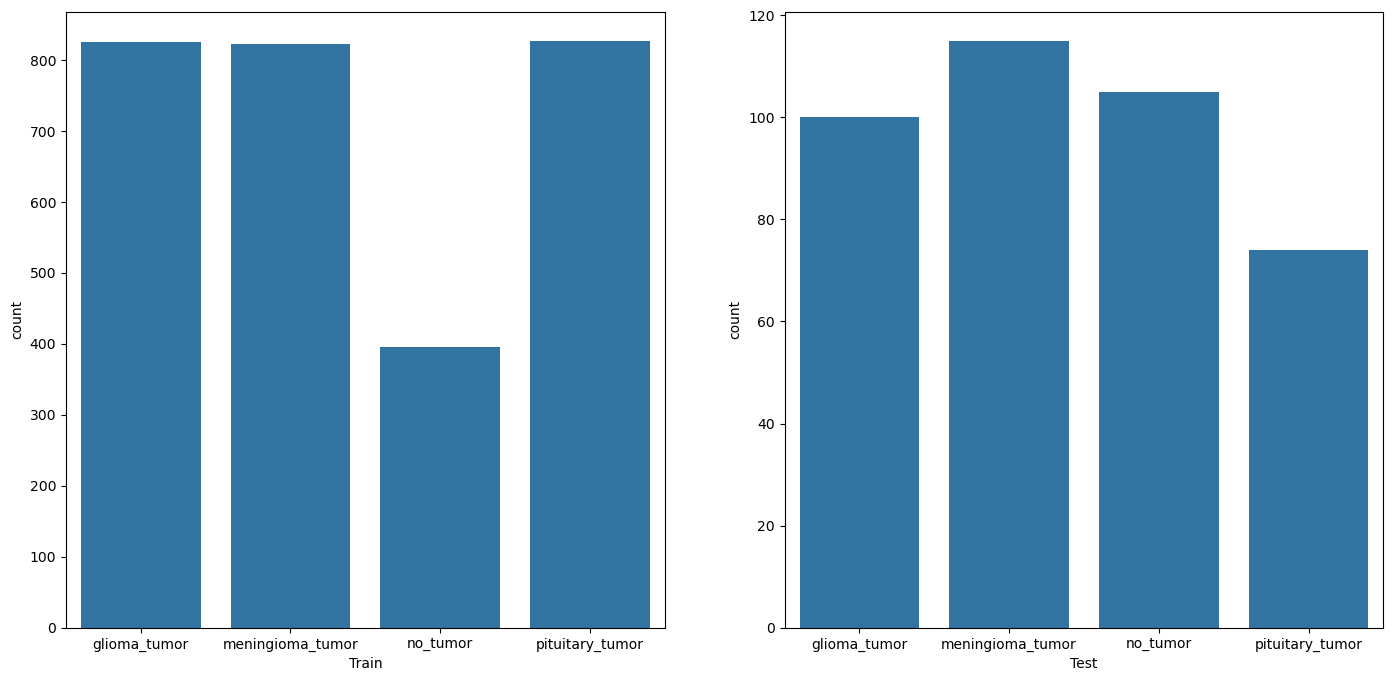

In [167]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [169]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=32, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # Changed to softmax
])


In [207]:
# Show model summary to verify architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 300, 300, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 300, 300, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 87616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,214,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,738,030 (128.70 MB)

 Trainable params: 11,245,924 (42.90 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 22,491,850 (85.80 MB)

In [244]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.optimizers import Adam

# # If train_y is one-hot encoded, get the class labels (index of 1 in each row)
# train_y_labels = np.argmax(train_y, axis=1)  # This should already be a 1D array, but we will flatten it just to be sure
# train_y_labels = train_y_labels.flatten()  # Ensure it's a flat 1D array

# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(train_y_labels), y=train_y_labels)
# class_weights_dict = dict(enumerate(class_weights))

# Compile the model with appropriate loss and metrics
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [173]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
train_y = to_categorical(train_y, num_classes=4)  # One-hot encode for train labels
val_y = to_categorical(val_y, num_classes=4)      # One-hot encode for validation labels

In [175]:
print(f"Shape of train_x: {train_x.shape}")
print(f"Shape of train_y: {train_y.shape}")


Shape of train_x: (2296, 300, 300, 3)
Shape of train_y: (2296, 4, 4)


In [193]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define a learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9  # Reduce by 10%

lr_scheduler = LearningRateScheduler(lr_schedule)


In [218]:
train_y_flat = train_y_flat.argmax(axis=-1)


In [220]:
class_weights_dict = {0: 1.0, 1: 2.0, 2: 3.0,3:4.0}


In [252]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
# Example of reshaping the data if it's image data but needs to be 1D features
train_x = train_x.reshape((train_x.shape[0], -1))  # Flatten the images to 1D vectors
val_x = val_x.reshape((val_x.shape[0], -1))  # Similarly reshape validation data

# Define the model for image input
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)))  # First convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer
model.add(Flatten())  # Flatten the 2D output to 1D
model.add(Dense(64, activation='relu'))  # Fully connected layer
model.add(Dense(3, activation='softmax'))  # Output layer with 3 units for 3 classes

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with the one-hot encoded labels
history = model.fit(
    train_x, train_y_flat_one_hot,  # Use one-hot encoded labels
    validation_data=(val_x, val_y),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 270000), dtype=float32). Expected shape (None, 300, 300, 3), but input has incompatible shape (None, 270000)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 270000), dtype=float32)
  • training=True
  • mask=None

In [216]:
print(set(class_weights_dict.keys()))
print(set(unique_labels))


{0, 1, 2, 3}
{0, 1, 2, 3}


In [38]:
model.save('my_model_sunway.h5')

## Key Notes
> Adding padding here to preserve the image shape

> Adding maxpool layer to get those pixels which have the highest intensity. Reduces the image size by 2.

> Took filters of 7*7 as image size if 300 * 300 thus it would help it to learn better.

> Taken a dropout layer, to avoid overfitting.

 > The image from data generator is of type 'uint8', you need to type cast it to 'float32'.

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


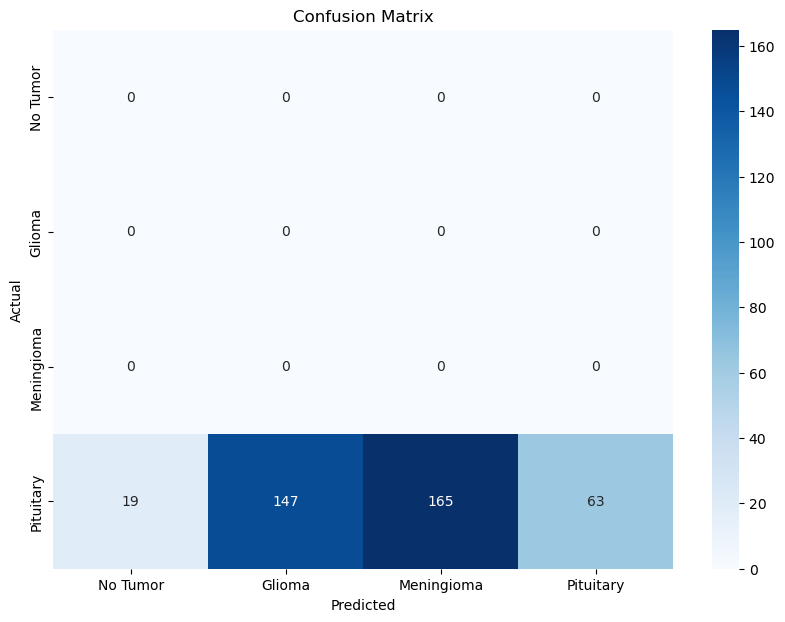

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model, and you already have test data loaded as 'test_img' and 'test_labels_encoded'

# Step 1: Make predictions on test data
y_pred_prob = model.predict(test_img)

# Step 2: Convert probabilities to class labels (for multiclass classification)
y_pred = np.argmax(y_pred_prob, axis=1)

# Step 3: Generate confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Tumor', 'Glioma', 'Meningioma', 'Pituitary'],
            yticklabels=['No Tumor', 'Glioma', 'Meningioma', 'Pituitary'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.layers[0].get_weights()[0].shape

In [ ]:
model.save('my_model2.keras')



# Conclusion

In [ ]:
! pip install streamlit -q

In [ ]:
! wget -q -O - ipv4.icanhazip.com

In [ ]:
! streamlit run /content/drive/MyDrive/ColabNotebooks/brain_tumor/Brain-Tumor-Classification-DataSet/stream.py & npx localtunnel --port 8501

In [ ]:
!wget -q -O - https://loca.lt/mytunnelpassword